In [ ]:
from regression_toolbox.model import Model, add_model, delete_model
from regression_toolbox.likelihood import Likelihood
from regression_toolbox.parameter import Parameter
from visualisation_toolbox.domain import Domain
from regression_toolbox.sampler import Sampler
from visualisation_toolbox.visualiser import Visualiser
from data_processing.sim_data_processor import SimDataProcessor
from data_processing.raw_data_processor import RawDataProcessor
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

os.chdir('/PhD_project/')

/build/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


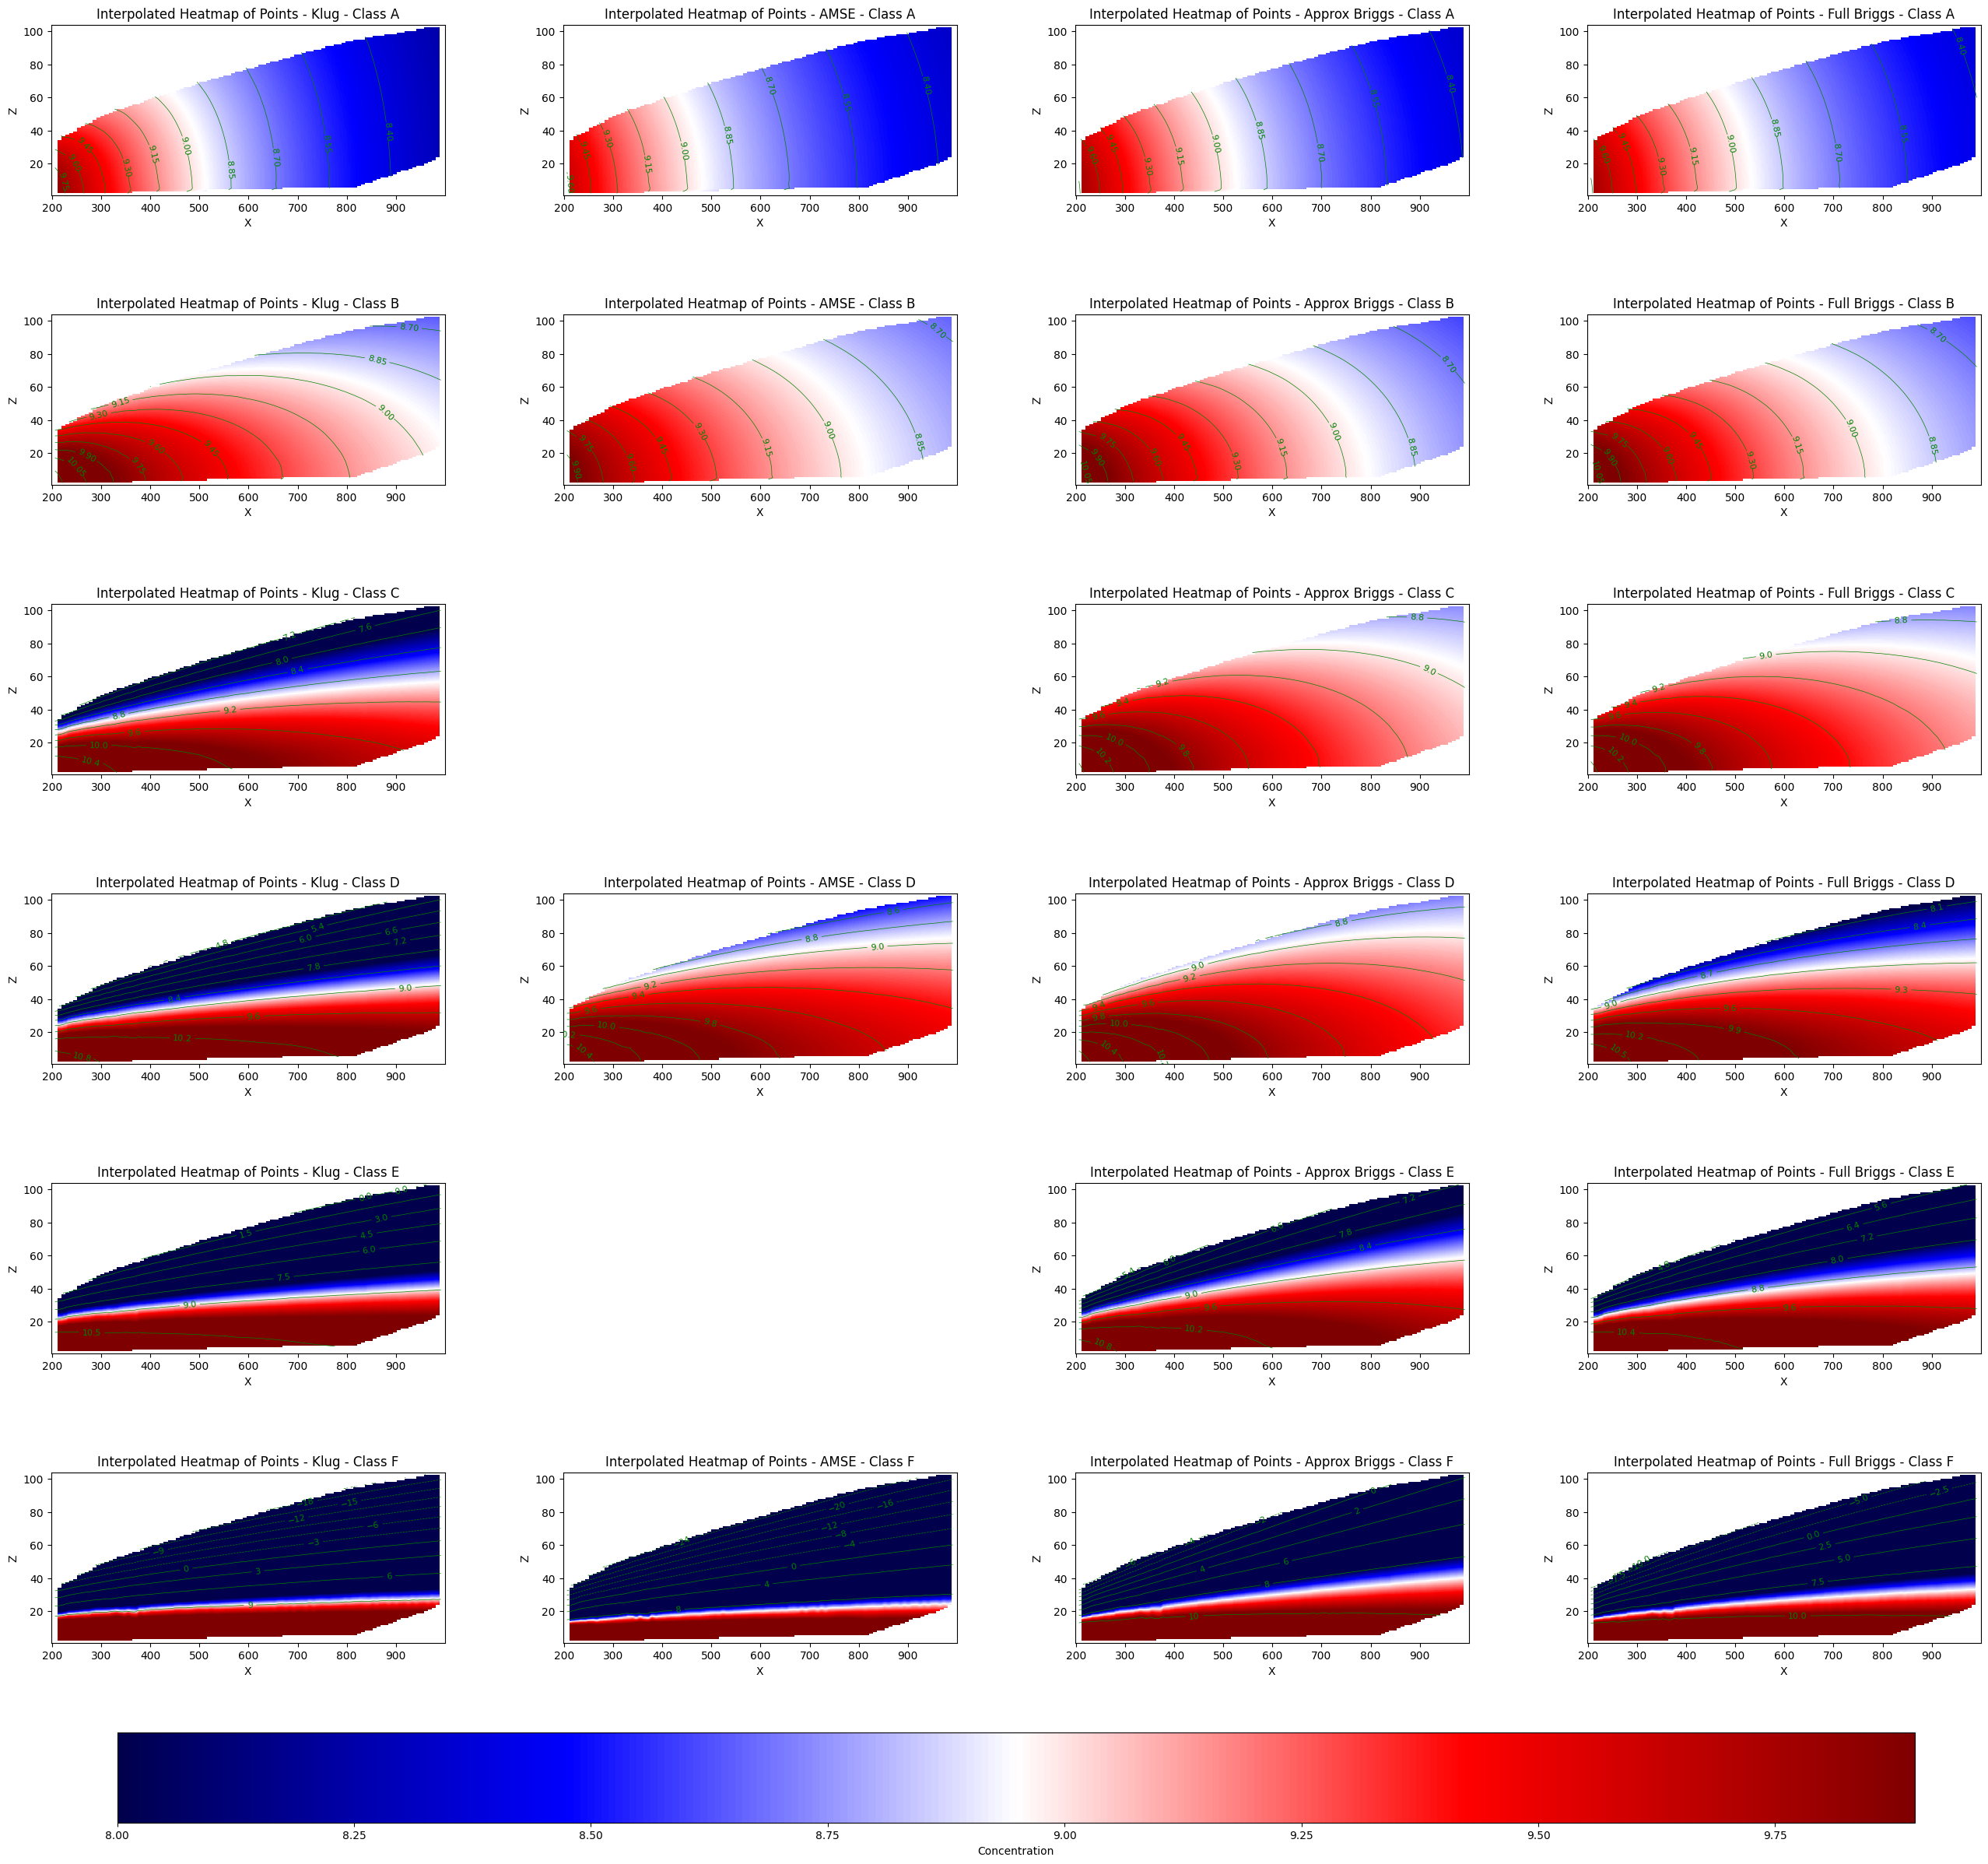

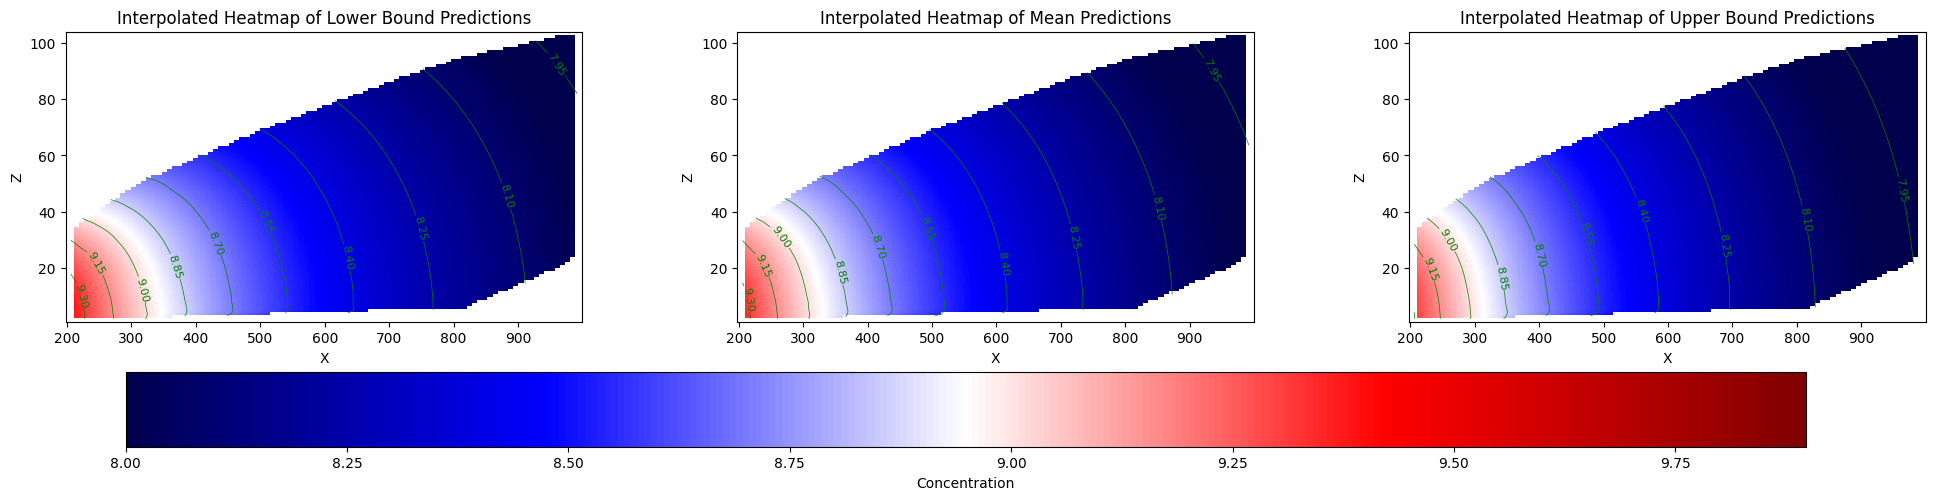

In [ ]:
from scipy.interpolate import griddata
import json

delete_model('log_full_briggs_gpm_norm')
add_model('log_full_briggs_gpm_norm', 
          "log10(Q/(2*pi*a_y*a_z*x^2*(1+c_y*x)^d_y*(1+c_z*x)^d_z)*exp(-y^2/(2*a_y^2*x^2*(1+c_y*x)^(2*d_y)))*(exp(-(z-H)^2/(2*a_z^2*x^2*(1+c_z*x)^(2*d_z)))+exp(-(z+H)^2/(2*a_z^2*x^2*(1+c_z*x)^(2*d_z)))))",
           dependent_variable='Concentration',
           independent_variables=['x','y','z'], 
           all_param_names=['H', 'Q', 'a_y', 'c_y', 'd_y', 'a_z', 'c_z', 'd_z'])

# report_title = 'GBR run with 100_100_25 gridding and a wide encompassing prior defined by ASME on R_y, R_z, b_y and b_z\n using an alternate version of the GPM without logerithmizing'

# ASME
R_y_ASME = [0.40, 0.36, None, 0.32, None, 0.31]
R_z_ASME = [0.40, 0.33, None, 0.22, None, 0.06]
b_y_ASME = [0.91, 0.86, None, 0.78, None, 0.71]
b_z_ASME = [0.91, 0.86, None, 0.78, None, 0.71]

# Klug

R_y_Klug = [0.469, 0.306, 0.230, 0.219, 0.237, 0.273]
R_z_Klug = [0.017, 0.072, 0.076, 0.140, 0.217, 0.262]
b_y_Klug = [0.903, 0.885, 0.855, 0.764, 0.691, 0.594]
b_z_Klug = [1.380, 1.021, 0.879, 0.727, 0.610, 0.500]

# Old method

I_y = [0.22, 0.16, 0.11, 0.08, 0.06, 0.04]
I_z = [0.2, 0.12, 0.08, 0.06, 0.03, 0.016]

# Full Briggs

a_y = [0.22, 0.16, 0.11, 0.08, 0.06, 0.04]
c_y = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
d_y = [-1/2, -1/2, -1/2, -1/2, -1/2, -1/2]
a_z = [0.2, 0.12, 0.08, 0.06, 0.03, 0.016]
c_z = [0, 0, 0.0002, 0.0015, 0.0003, 0.0003]
d_z = [1, 1, -1/2, -1/2, -1, -1]

classes = ['A', 'B', 'C', 'D', 'E', 'F']

sim_domain = Domain('cone_from_source_z_limited').add_domain_param('r',1000).add_domain_param('theta',np.pi/8).add_domain_param('source', [0,0,5]).add_domain_param('resolution',100).add_domain_param('y_slice',0)
points = sim_domain.create_domain_slice('y_slice')

# Extract x, y, z coordinates
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

df_points = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Generating data for class C
min_vals = []
max_vals = []

for i in range(len(classes)):
    sim_model_Klug = Model('log_alt_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('R_y',R_y_Klug[i]).add_fixed_model_param('R_z',R_z_Klug[i]).add_fixed_model_param('b_y',b_y_Klug[i]).add_fixed_model_param('b_z',b_z_Klug[i]).add_fixed_model_param('Q',3.41e13)
    c_klug = sim_model_Klug.get_model()(pd.Series({}), df_points)

    if not R_y_ASME[i] is None:
        sim_model_AMSE = Model('log_alt_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('R_y',R_y_ASME[i]).add_fixed_model_param('R_z',R_z_ASME[i]).add_fixed_model_param('b_y',b_y_ASME[i]).add_fixed_model_param('b_z',b_z_ASME[i]).add_fixed_model_param('Q',3.41e13)
        c_amse = sim_model_AMSE.get_model()(pd.Series({}), df_points)
    else:
        c_amse = c_klug

    
    sim_model_old = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y[i]).add_fixed_model_param('I_z',I_z[i]).add_fixed_model_param('Q',3.41e13)
    c_old = sim_model_old.get_model()(pd.Series({}), df_points)

    sim_model_full_briggs = Model('log_full_briggs_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('Q',3.41e13).add_fixed_model_param('a_y',a_y[i]).add_fixed_model_param('c_y',c_y[i]).add_fixed_model_param('d_y',d_y[i]).add_fixed_model_param('a_z',a_z[i]).add_fixed_model_param('c_z',c_z[i]).add_fixed_model_param('d_z',d_z[i])
    c_full_briggs = sim_model_full_briggs.get_model()(pd.Series({}), df_points)

    klug_header = f'c_klug_{classes[i]}'
    amse_header = f'c_amse_{classes[i]}'
    old_header = f'c_old_{classes[i]}'
    full_briggs_header = f'c_full_briggs_{classes[i]}'

    headers = []
    headers.append(klug_header)
    headers.append(amse_header)
    headers.append(old_header)
    headers.append(full_briggs_header)

    df_points[klug_header] = c_klug
    df_points[amse_header] = c_amse
    df_points[old_header] = c_old
    df_points[full_briggs_header] = c_full_briggs

df_points.replace([np.inf, -np.inf], np.nan, inplace=True)
df_points.dropna(inplace=True)

# min_val = df_points[headers].quantile(0.10).quantile(0.10)
min_val = 8
max_val = df_points[headers].quantile(0.90).max()


x = df_points.x
z = df_points.z
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]


fig, axs = plt.subplots(6, 4, figsize=(32, 30))
for i in range(len(classes)):
    klug_header = f'c_klug_{classes[i]}'
    amse_header = f'c_amse_{classes[i]}'
    old_header = f'c_old_{classes[i]}'
    full_briggs_header = f'c_full_briggs_{classes[i]}'

    c_klug = df_points[klug_header]
    c_amse = df_points[amse_header] if not R_y_ASME[i] is None else None
    c_old = df_points[old_header]
    c_full_briggs = df_points[full_briggs_header]

    # Interpolate and plot
    grid_z_klug = griddata((x, z), c_klug, (grid_x, grid_z), method='cubic')
    
    # Plot for Klug
    im_klug = axs[i, 0].imshow(grid_z_klug.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
    axs[i, 0].set_title(f'Interpolated Heatmap of Points - Klug - Class {classes[i]}')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Z')
    axs[i, 0].set_aspect('auto')
    
    # Add contour lines and labels
    contour_klug = axs[i, 0].contour(grid_x, grid_z, grid_z_klug, levels=10, colors='green', linewidths=0.5)
    axs[i, 0].clabel(contour_klug, inline=True, fontsize=8)
    
    # Plot for AMSE if available
    if c_amse is not None:
        grid_z_amse = griddata((x, z), c_amse, (grid_x, grid_z), method='cubic')
        im_amse = axs[i, 1].imshow(grid_z_amse.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
        axs[i, 1].set_title(f'Interpolated Heatmap of Points - AMSE - Class {classes[i]}')
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Z')
        axs[i, 1].set_aspect('auto')
        
        # Add contour lines and labels
        contour_amse = axs[i, 1].contour(grid_x, grid_z, grid_z_amse, levels=10, colors='green', linewidths=0.5)
        axs[i, 1].clabel(contour_amse, inline=True, fontsize=8)
    else:
        axs[i, 1].axis('off')

    # Plot for Old Method
    grid_z_old = griddata((x, z), c_old, (grid_x, grid_z), method='cubic')
    im_old = axs[i, 2].imshow(grid_z_old.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
    axs[i, 2].set_title(f'Interpolated Heatmap of Points - Approx Briggs - Class {classes[i]}')
    axs[i, 2].set_xlabel('X')
    axs[i, 2].set_ylabel('Z')
    axs[i, 2].set_aspect('auto')
    
    # Add contour lines and labels
    contour_old = axs[i, 2].contour(grid_x, grid_z, grid_z_old, levels=10, colors='green', linewidths=0.5)
    axs[i, 2].clabel(contour_old, inline=True, fontsize=8)

    # Plot for Full Briggs
    grid_z_full_briggs = griddata((x, z), c_full_briggs, (grid_x, grid_z), method='cubic')
    im_full_briggs = axs[i, 3].imshow(grid_z_full_briggs.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
    axs[i, 3].set_title(f'Interpolated Heatmap of Points - Full Briggs - Class {classes[i]}')
    axs[i, 3].set_xlabel('X')
    axs[i, 3].set_ylabel('Z')
    axs[i, 3].set_aspect('auto')

    # Add contour lines and labels
    contour_full_briggs = axs[i, 3].contour(grid_x, grid_z, grid_z_full_briggs, levels=10, colors='green', linewidths=0.5)
    axs[i, 3].clabel(contour_full_briggs, inline=True, fontsize=8)

# Adjust vertical and horizontal space between rows and columns
fig.subplots_adjust(hspace=0.7, wspace=0.3)

# Add a colorbar at the bottom that represents all plots
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=min_val, vmax=max_val)),
                    ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label("Concentration")

plt.show()

# Input results path here:
results_path = '/PhD_project/results/inference_results/GBR_data_gridded_100_100_25/general_instances/instance_5'

if not os.path.exists(results_path):
    raise Exception('Results path does not exist')

with open(f'{results_path}/summary.json', 'r') as file:
    summary_data = json.load(file)

# Extract the data
I_y_pred_mean = summary_data['overall']['I_y']['mean']
I_z_pred_mean = summary_data['overall']['I_z']['mean']
Q_pred_mean = summary_data['overall']['Q']['mean']

I_y_pred_lower = summary_data['overall']['I_y']['lower']
I_z_pred_lower = summary_data['overall']['I_z']['lower']
Q_pred_lower = summary_data['overall']['Q']['lower']

I_y_pred_upper = summary_data['overall']['I_y']['upper']
I_z_pred_upper = summary_data['overall']['I_z']['upper']
Q_pred_upper = summary_data['overall']['Q']['upper']

pred_model_mean = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y_pred_mean).add_fixed_model_param('I_z',I_z_pred_mean).add_fixed_model_param('Q',Q_pred_mean)
pred_model_lower = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y_pred_lower).add_fixed_model_param('I_z',I_z_pred_lower).add_fixed_model_param('Q',Q_pred_lower)
pred_model_upper = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y_pred_upper).add_fixed_model_param('I_z',I_z_pred_upper).add_fixed_model_param('Q',Q_pred_upper)

c_pred_mean = pred_model_mean.get_model()(pd.Series({}), df_points)
c_pred_lower = pred_model_lower.get_model()(pd.Series({}), df_points)
c_pred_upper = pred_model_upper.get_model()(pd.Series({}), df_points)
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# Interpolate and plot
grid_z_pred_mean = griddata((x, z), c_pred_mean, (grid_x, grid_z), method='cubic')
grid_z_pred_lower = griddata((x, z), c_pred_lower, (grid_x, grid_z), method='cubic')
grid_z_pred_upper = griddata((x, z), c_pred_upper, (grid_x, grid_z), method='cubic')

# Plot for lower predictions
axs[0].imshow(grid_z_pred_lower.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
axs[0].set_title(f'Interpolated Heatmap of Lower Bound Predictions')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Z')
axs[0].set_aspect('auto')
contour_pred = axs[0].contour(grid_x, grid_z, grid_z_pred_lower, levels=10, colors='green', linewidths=0.5)
axs[0].clabel(contour_pred, inline=True, fontsize=8)

# Plot for mean predictions
axs[1].imshow(grid_z_pred_mean.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
axs[1].set_title(f'Interpolated Heatmap of Mean Predictions')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Z')
axs[1].set_aspect('auto')
contour_pred = axs[1].contour(grid_x, grid_z, grid_z_pred_mean, levels=10, colors='green', linewidths=0.5)
axs[1].clabel(contour_pred, inline=True, fontsize=8)

# Plot for upper predictions
axs[2].imshow(grid_z_pred_upper.T, extent=(min(x), max(x), min(z), max(z)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
axs[2].set_title(f'Interpolated Heatmap of Upper Bound Predictions')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Z')
axs[2].set_aspect('auto')
contour_pred = axs[2].contour(grid_x, grid_z, grid_z_pred_upper, levels=10, colors='green', linewidths=0.5)
axs[2].clabel(contour_pred, inline=True, fontsize=8)

# Adjust space between subplots to make room for the colorbar
fig.subplots_adjust(bottom=0.3, hspace=0.6, wspace=0.3)

# Define the colorbar position relative to the entire figure
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.15])  # [left, bottom, width, height]

# Create the colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=min_val, vmax=max_val)),
                    cax=cbar_ax, orientation='horizontal')
cbar.set_label("Concentration")


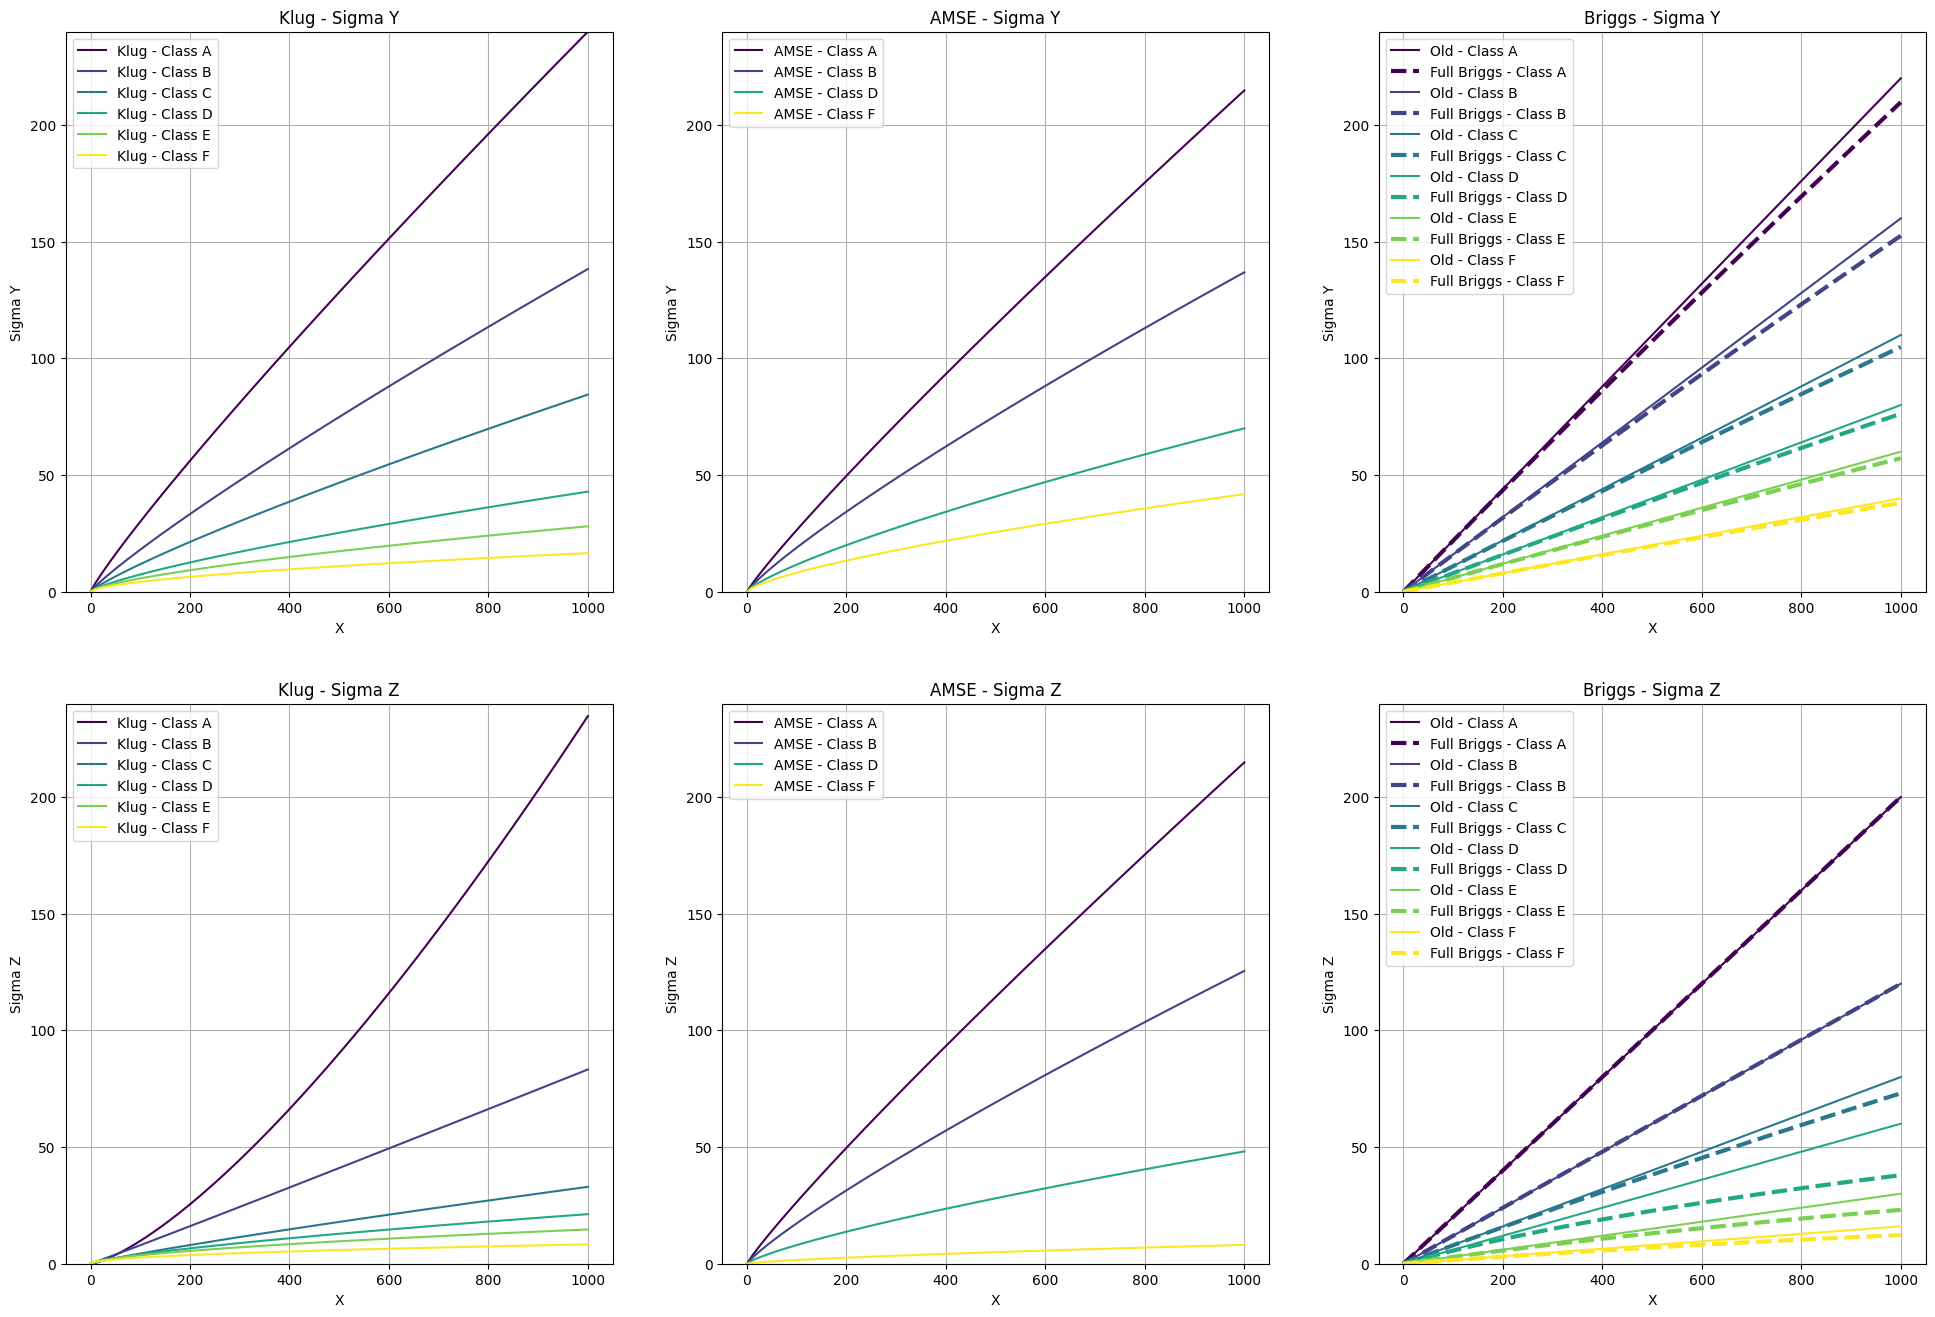

In [3]:
x = np.linspace(0, 1000, 100)

def amse_klug_def(x, R_y, R_z, b_y, b_z):
    sigma_y = R_y * x ** b_y
    sigma_z = R_z * x ** b_z
    return sigma_y, sigma_z

def old_def(x, I_y, I_z):
    sigma_y = I_y*x
    sigma_z = I_z*x
    return sigma_y, sigma_z

def full_briggs(x, a, c, d):
    sigma = a*x*(1+c*x)**d
    return sigma

final_max_val = 0

colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))

fig, axs = plt.subplots(2, 3, figsize=(24, 16))
for i in range(len(classes)):
    
    klug_sigma_y, klug_sigma_z = amse_klug_def(x, R_y_Klug[i], R_z_Klug[i], b_y_Klug[i], b_z_Klug[i])
    axs[0, 0].plot(x, klug_sigma_y, label=f'Klug - Class {classes[i]}', color = colors[i])
    axs[1, 0].plot(x, klug_sigma_z, label=f'Klug - Class {classes[i]}', color = colors[i])
    
    if not R_y_ASME[i] is None:
        amse_sigma_y, amse_sigma_z = amse_klug_def(x, R_y_ASME[i], R_z_ASME[i], b_y_ASME[i], b_z_ASME[i])
        axs[0, 1].plot(x, amse_sigma_y, label=f'AMSE - Class {classes[i]}', color = colors[i])
        axs[1, 1].plot(x, amse_sigma_z, label=f'AMSE - Class {classes[i]}', color = colors[i])
    
    old_sigma_y, old_sigma_z = old_def(x, I_y[i], I_z[i])
    full_briggs_sigma_y = full_briggs(x, a_y[i], c_y[i], d_y[i])
    full_briggs_sigma_z = full_briggs(x, a_z[i], c_z[i], d_z[i])
    axs[0, 2].plot(x, old_sigma_y, label=f'Old - Class {classes[i]}', color = colors[i])
    axs[1, 2].plot(x, old_sigma_z, label=f'Old - Class {classes[i]}', color = colors[i])
    axs[0, 2].plot(x, full_briggs_sigma_y, linestyle = 'dashed', label=f'Full Briggs - Class {classes[i]}', color = colors[i], linewidth=3)
    axs[1, 2].plot(x, full_briggs_sigma_z, linestyle='dashed', label=f'Full Briggs - Class {classes[i]}', color = colors[i], linewidth=3)

    max_val = max(max(klug_sigma_y), max(klug_sigma_z), max(amse_sigma_y), max(amse_sigma_z), max(old_sigma_y), max(old_sigma_z))
    final_max_val = max_val if max_val > final_max_val else final_max_val



axs[0, 0].set_title('Klug - Sigma Y')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Sigma Y')
axs[0, 0].set_ylim(0, final_max_val)
axs[0, 0].legend()
axs[0, 0].grid()

axs[1, 0].set_title('Klug - Sigma Z')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Sigma Z')
axs[1, 0].set_ylim(0, final_max_val)
axs[1, 0].legend()
axs[1, 0].grid()

axs[0, 1].set_title('AMSE - Sigma Y')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Sigma Y')
axs[0, 1].set_ylim(0, final_max_val)
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 1].set_title('AMSE - Sigma Z')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Sigma Z')
axs[1, 1].set_ylim(0, final_max_val)
axs[1, 1].legend()
axs[1, 1].grid()

axs[0, 2].set_title('Briggs - Sigma Y')
axs[0, 2].set_xlabel('X')
axs[0, 2].set_ylabel('Sigma Y')
axs[0, 2].set_ylim(0, final_max_val)
axs[0, 2].legend()
axs[0, 2].grid()

axs[1, 2].set_title('Briggs - Sigma Z')
axs[1, 2].set_xlabel('X')
axs[1, 2].set_ylabel('Sigma Z')
axs[1, 2].set_ylim(0, final_max_val)
axs[1, 2].legend()
axs[1, 2].grid()

plt.show()


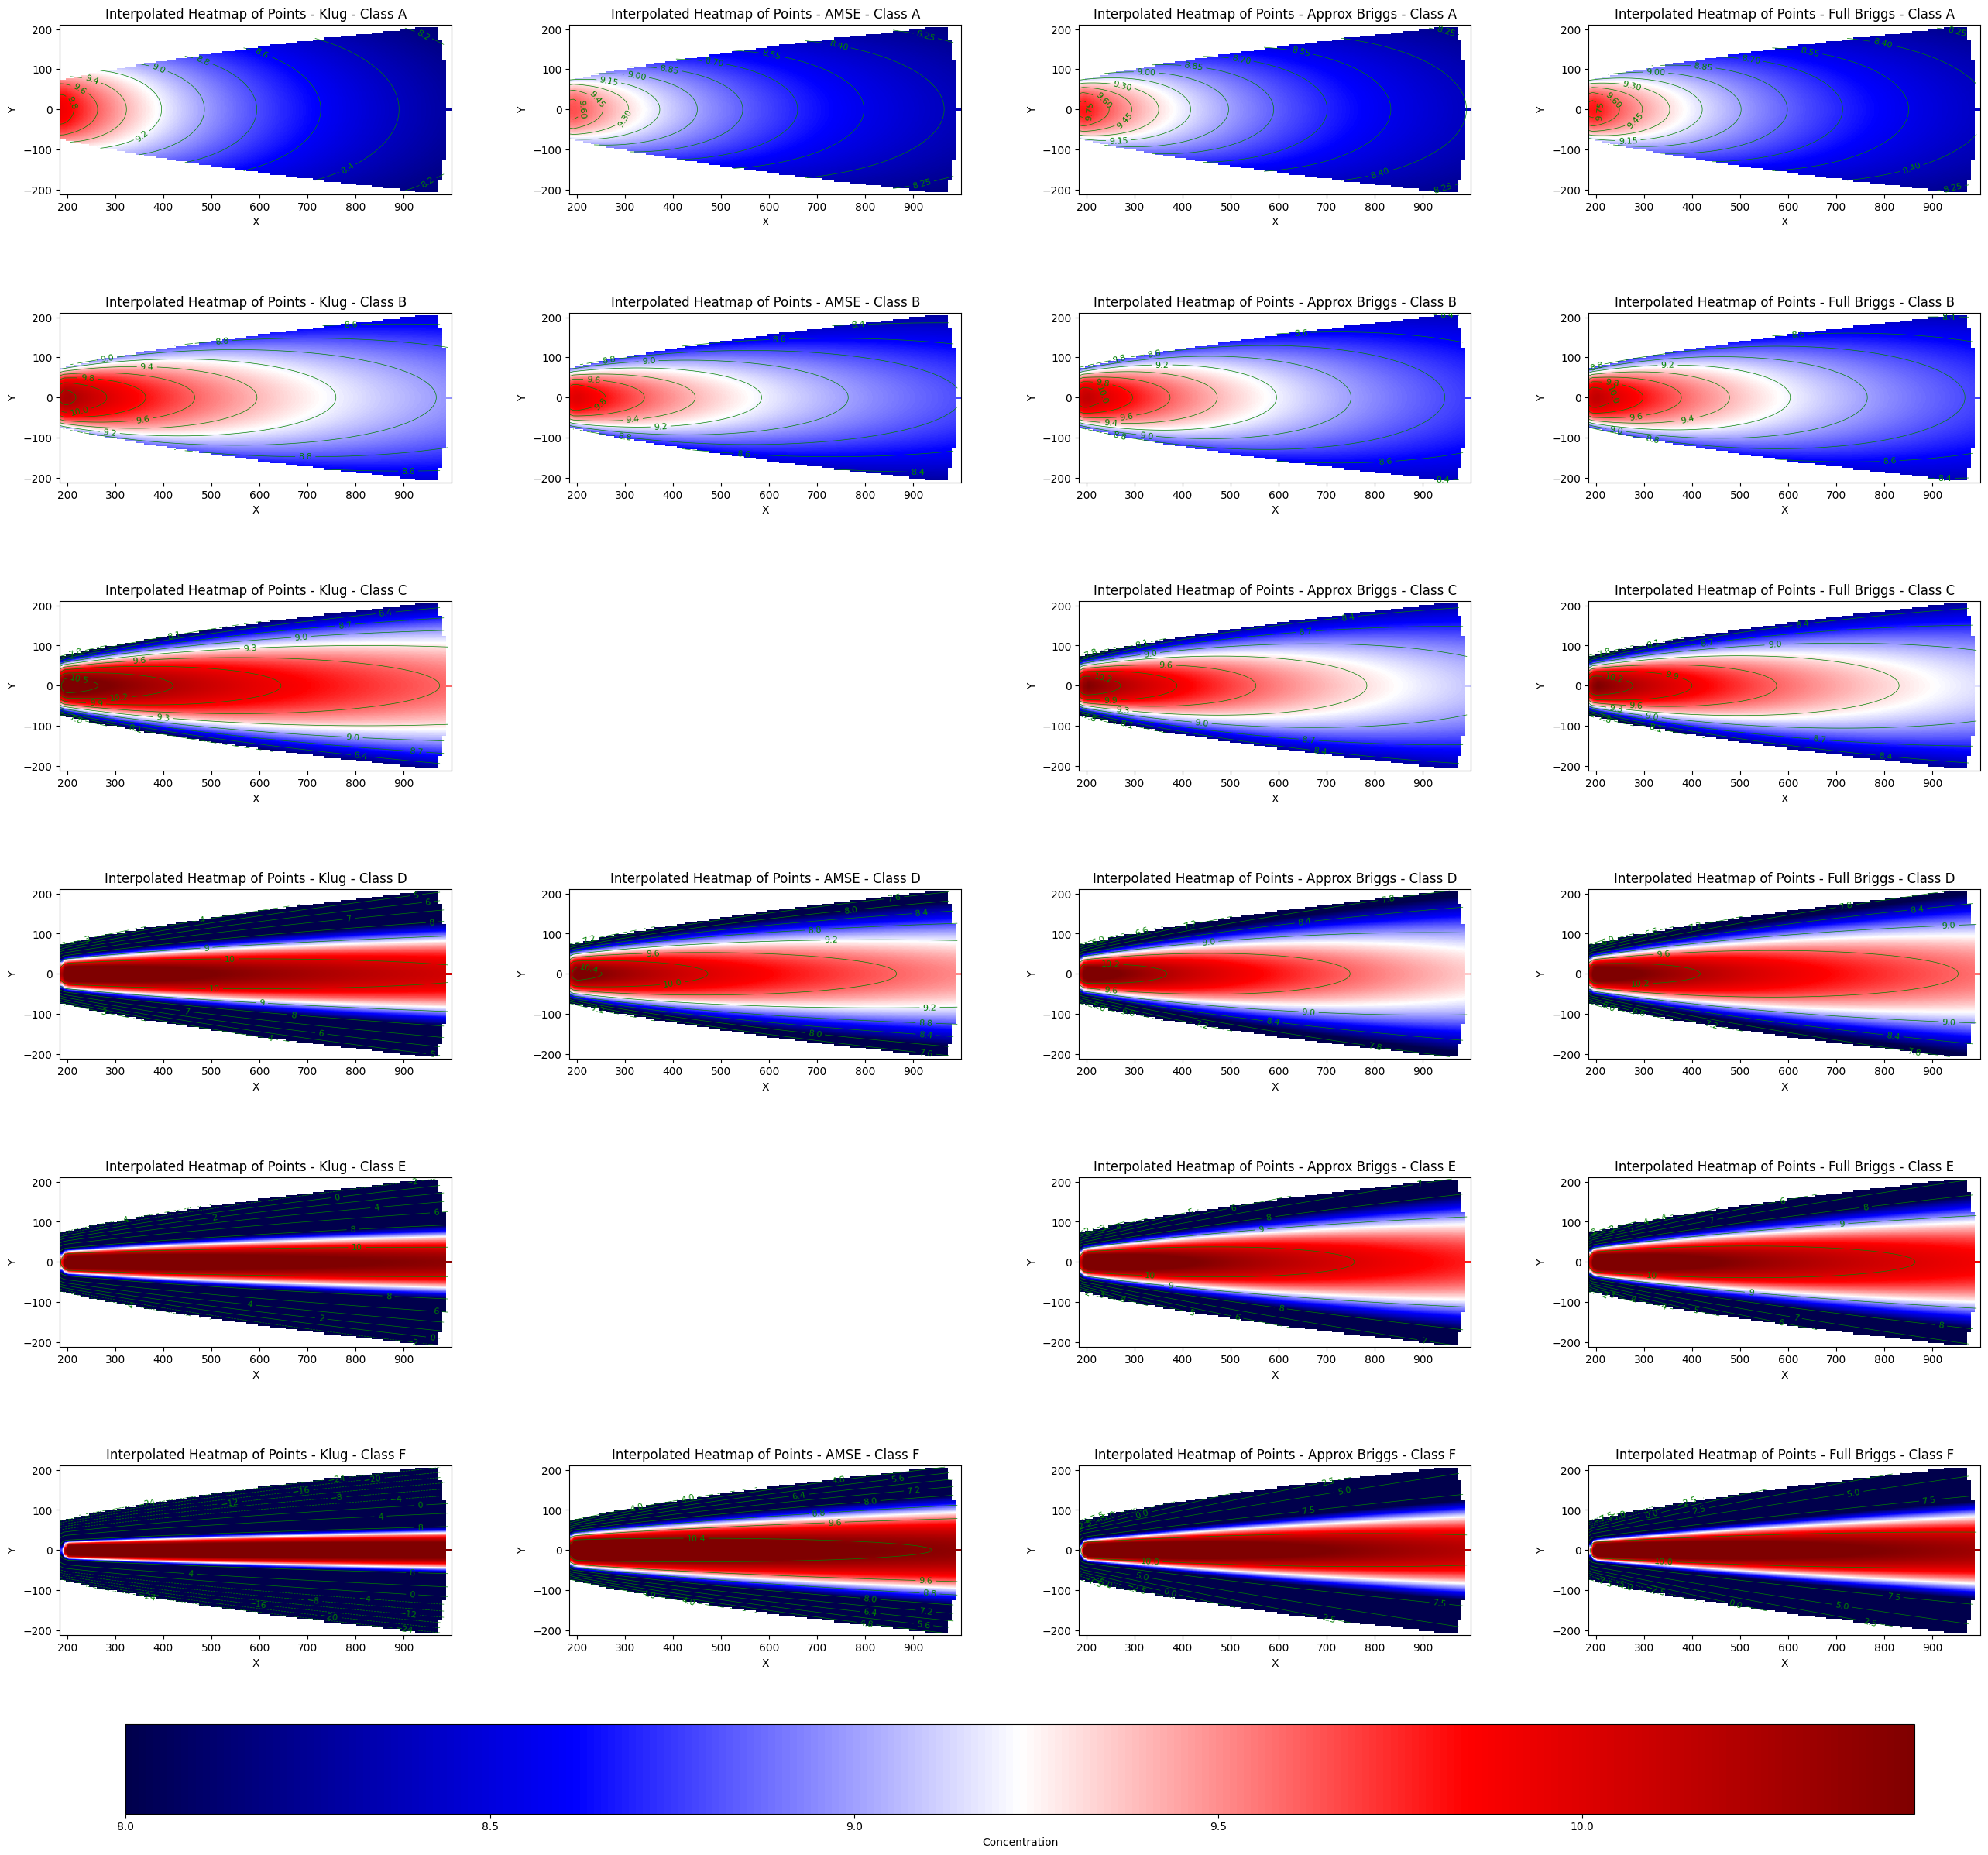

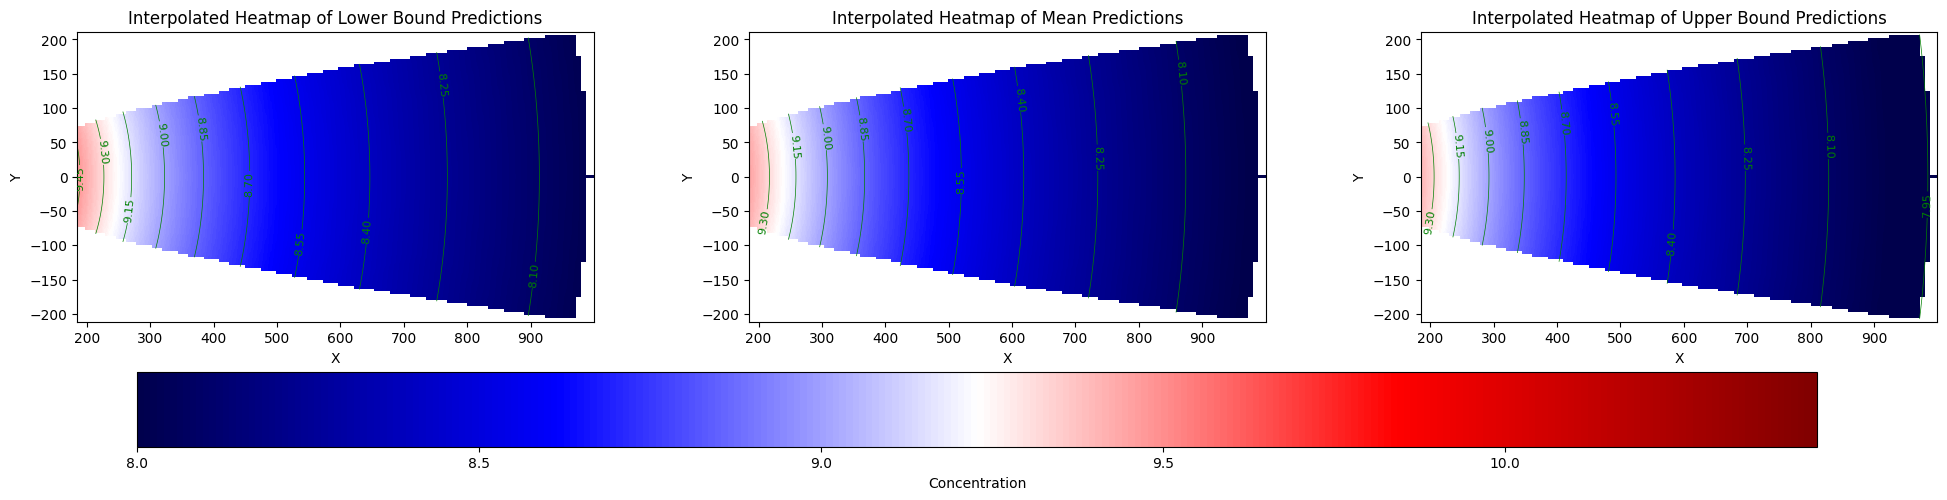

In [4]:
from scipy.interpolate import griddata
import json

# delete_model('log_alt_gpm_norm')
# add_model('log_alt_gpm_norm', 
#           "log10(Q/(2*pi*R_y*R_z*x^(b_y+b_z))*exp(-y^2/(2*R_y^2*x^(2*b_y)))*(exp(-(z-H)^2/(2*R_z^2*x^(2*b_z)))+exp(-(z+H)^2/(2*R_z^2*x^(2*b_z)))))",
#            dependent_variables=['Concentration'],
#            independent_variables=['x','y','z'], 
#            all_param_names=['Q','R_y','R_z','b_y','b_z','H'])



# ASME
R_y_ASME = [0.40, 0.36, None, 0.32, None, 0.31]
R_z_ASME = [0.40, 0.33, None, 0.22, None, 0.06]
b_y_ASME = [0.91, 0.86, None, 0.78, None, 0.71]
b_z_ASME = [0.91, 0.86, None, 0.78, None, 0.71]

# Klug

R_y_Klug = [0.469, 0.306, 0.230, 0.219, 0.237, 0.273]
R_z_Klug = [0.017, 0.072, 0.076, 0.140, 0.217, 0.262]
b_y_Klug = [0.903, 0.885, 0.855, 0.764, 0.691, 0.594]
b_z_Klug = [1.380, 1.021, 0.879, 0.727, 0.610, 0.500]

# Old method

I_y = [0.22, 0.16, 0.11, 0.08, 0.06, 0.04]
I_z = [0.2, 0.12, 0.08, 0.06, 0.03, 0.016]

classes = ['A', 'B', 'C', 'D', 'E', 'F']

sim_domain = Domain('cone_from_source_z_limited').add_domain_param('r',1000).add_domain_param('theta',np.pi/8).add_domain_param('source', [0,0,5]).add_domain_param('resolution',100).add_domain_param('z_slice',5)
points = sim_domain.create_domain_slice('z_slice')

# Extract x, y, z coordinates
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

df_points = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Generating data for class C
min_vals = []
max_vals = []

for i in range(len(classes)):
    sim_model_Klug = Model('log_alt_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('R_y',R_y_Klug[i]).add_fixed_model_param('R_z',R_z_Klug[i]).add_fixed_model_param('b_y',b_y_Klug[i]).add_fixed_model_param('b_z',b_z_Klug[i]).add_fixed_model_param('Q',3.41e13)
    c_klug = sim_model_Klug.get_model()(pd.Series({}), df_points)

    if not R_y_ASME[i] is None:
        sim_model_AMSE = Model('log_alt_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('R_y',R_y_ASME[i]).add_fixed_model_param('R_z',R_z_ASME[i]).add_fixed_model_param('b_y',b_y_ASME[i]).add_fixed_model_param('b_z',b_z_ASME[i]).add_fixed_model_param('Q',3.41e13)
        c_amse = sim_model_AMSE.get_model()(pd.Series({}), df_points)
    else:
        c_amse = c_klug

    
    sim_model_old = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y[i]).add_fixed_model_param('I_z',I_z[i]).add_fixed_model_param('Q',3.41e13)
    c_old = sim_model_old.get_model()(pd.Series({}), df_points)

    sim_model_full_briggs = Model('log_full_briggs_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('Q',3.41e13).add_fixed_model_param('a_y',a_y[i]).add_fixed_model_param('c_y',c_y[i]).add_fixed_model_param('d_y',d_y[i]).add_fixed_model_param('a_z',a_z[i]).add_fixed_model_param('c_z',c_z[i]).add_fixed_model_param('d_z',d_z[i])
    c_full_briggs = sim_model_full_briggs.get_model()(pd.Series({}), df_points)

    klug_header = f'c_klug_{classes[i]}'
    amse_header = f'c_amse_{classes[i]}'
    old_header = f'c_old_{classes[i]}'
    full_briggs_header = f'c_full_briggs_{classes[i]}'

    headers = []
    headers.append(klug_header)
    headers.append(amse_header)
    headers.append(old_header)
    headers.append(full_briggs_header)

    df_points[klug_header] = c_klug
    df_points[amse_header] = c_amse
    df_points[old_header] = c_old
    df_points[full_briggs_header] = c_full_briggs

df_points.replace([np.inf, -np.inf], np.nan, inplace=True)
df_points.dropna(inplace=True)

# min_val = df_points[headers].quantile(0.10).quantile(0.10)
min_val = 8
max_val = df_points[headers].quantile(0.90).max()


x = df_points.x
y = df_points.y
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]


fig, axs = plt.subplots(6, 4, figsize=(32, 30))
for i in range(len(classes)):
    klug_header = f'c_klug_{classes[i]}'
    amse_header = f'c_amse_{classes[i]}'
    old_header = f'c_old_{classes[i]}'
    full_briggs_header = f'c_full_briggs_{classes[i]}'

    c_klug = df_points[klug_header]
    c_amse = df_points[amse_header] if not R_y_ASME[i] is None else None
    c_old = df_points[old_header]
    c_full_briggs = df_points[full_briggs_header]

    # Interpolate and plot
    grid_y_klug = griddata((x, y), c_klug, (grid_x, grid_y), method='cubic')
    
    # Plot for Klug
    im_klug = axs[i, 0].imshow(grid_y_klug.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
    axs[i, 0].set_title(f'Interpolated Heatmap of Points - Klug - Class {classes[i]}')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_aspect('auto')
    
    # Add contour lines and labels
    contour_klug = axs[i, 0].contour(grid_x, grid_y, grid_y_klug, levels=10, colors='green', linewidths=0.5)
    axs[i, 0].clabel(contour_klug, inline=True, fontsize=8)
    
    # Plot for AMSE if available
    if c_amse is not None:
        grid_y_amse = griddata((x, y), c_amse, (grid_x, grid_y), method='cubic')
        im_amse = axs[i, 1].imshow(grid_y_amse.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
        axs[i, 1].set_title(f'Interpolated Heatmap of Points - AMSE - Class {classes[i]}')
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_aspect('auto')
        
        # Add contour lines and labels
        contour_amse = axs[i, 1].contour(grid_x, grid_y, grid_y_amse, levels=10, colors='green', linewidths=0.5)
        axs[i, 1].clabel(contour_amse, inline=True, fontsize=8)
    else:
        axs[i, 1].axis('off')

    # Plot for Old Method
    grid_y_old = griddata((x, y), c_old, (grid_x, grid_y), method='cubic')
    im_old = axs[i, 2].imshow(grid_y_old.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
    axs[i, 2].set_title(f'Interpolated Heatmap of Points - Approx Briggs - Class {classes[i]}')
    axs[i, 2].set_xlabel('X')
    axs[i, 2].set_ylabel('Y')
    axs[i, 2].set_aspect('auto')
    
    # Add contour lines and labels
    contour_old = axs[i, 2].contour(grid_x, grid_y, grid_y_old, levels=10, colors='green', linewidths=0.5)
    axs[i, 2].clabel(contour_old, inline=True, fontsize=8)

    # Plot for Full Briggs
    grid_y_full_briggs = griddata((x, y), c_full_briggs, (grid_x, grid_y), method='cubic')
    im_full_briggs = axs[i, 3].imshow(grid_y_full_briggs.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
    axs[i, 3].set_title(f'Interpolated Heatmap of Points - Full Briggs - Class {classes[i]}')
    axs[i, 3].set_xlabel('X')
    axs[i, 3].set_ylabel('Y')
    axs[i, 3].set_aspect('auto')

    # Add contour lines and labels
    contour_full_briggs = axs[i, 3].contour(grid_x, grid_y, grid_y_full_briggs, levels=10, colors='green', linewidths=0.5)
    axs[i, 3].clabel(contour_full_briggs, inline=True, fontsize=8)

# Adjust vertical and horizontal space between rows and columns
fig.subplots_adjust(hspace=0.7, wspace=0.3)

# Add a colorbar at the bottom that represents all plots
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=min_val, vmax=max_val)),
                    ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label("Concentration")

plt.show()


# Input results path here:
results_path = '/PhD_project/results/inference_results/GBR_data_gridded_100_100_25/general_instances/instance_5'

if not os.path.exists(results_path):
    raise Exception('Results path does not exist')

with open(f'{results_path}/summary.json', 'r') as file:
    summary_data = json.load(file)

# Extract the data
I_y_pred_mean = summary_data['overall']['I_y']['mean']
I_z_pred_mean = summary_data['overall']['I_z']['mean']
Q_pred_mean = summary_data['overall']['Q']['mean']

I_y_pred_lower = summary_data['overall']['I_y']['lower']
I_z_pred_lower = summary_data['overall']['I_z']['lower']
Q_pred_lower = summary_data['overall']['Q']['lower']

I_y_pred_upper = summary_data['overall']['I_y']['upper']
I_z_pred_upper = summary_data['overall']['I_z']['upper']
Q_pred_upper = summary_data['overall']['Q']['upper']

pred_model_mean = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y_pred_mean).add_fixed_model_param('I_z',I_z_pred_mean).add_fixed_model_param('Q',Q_pred_mean)
pred_model_lower = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y_pred_lower).add_fixed_model_param('I_z',I_z_pred_lower).add_fixed_model_param('Q',Q_pred_lower)
pred_model_upper = Model('log_gpm_norm').add_fixed_model_param('H', 5).add_fixed_model_param('I_y',I_y_pred_upper).add_fixed_model_param('I_z',I_z_pred_upper).add_fixed_model_param('Q',Q_pred_upper)

c_pred_mean = pred_model_mean.get_model()(pd.Series({}), df_points)
c_pred_lower = pred_model_lower.get_model()(pd.Series({}), df_points)
c_pred_upper = pred_model_upper.get_model()(pd.Series({}), df_points)
fig, axs = plt.subplots(1, 3, figsize=(24, 5))

# Interpolate and plot
grid_y_pred_mean = griddata((x, y), c_pred_mean, (grid_x, grid_y), method='cubic')
grid_y_pred_lower = griddata((x, y), c_pred_lower, (grid_x, grid_y), method='cubic')
grid_y_pred_upper = griddata((x, y), c_pred_upper, (grid_x, grid_y), method='cubic')

# Plot for lower predictions
axs[0].imshow(grid_y_pred_lower.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
axs[0].set_title(f'Interpolated Heatmap of Lower Bound Predictions')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_aspect('auto')
contour_pred = axs[0].contour(grid_x, grid_y, grid_y_pred_lower, levels=10, colors='green', linewidths=0.5)
axs[0].clabel(contour_pred, inline=True, fontsize=8)

# Plot for mean predictions
axs[1].imshow(grid_y_pred_mean.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
axs[1].set_title(f'Interpolated Heatmap of Mean Predictions')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_aspect('auto')
contour_pred = axs[1].contour(grid_x, grid_y, grid_y_pred_mean, levels=10, colors='green', linewidths=0.5)
axs[1].clabel(contour_pred, inline=True, fontsize=8)

# Plot for upper predictions
axs[2].imshow(grid_y_pred_upper.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='seismic', vmin=min_val, vmax=max_val)
axs[2].set_title(f'Interpolated Heatmap of Upper Bound Predictions')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_aspect('auto')
contour_pred = axs[2].contour(grid_x, grid_y, grid_y_pred_upper, levels=10, colors='green', linewidths=0.5)
axs[2].clabel(contour_pred, inline=True, fontsize=8)

# Adjust space between subplots to make room for the colorbar
fig.subplots_adjust(bottom=0.3, hspace=0.6, wspace=0.3)

# Define the colorbar position relative to the entire figure
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.15])  # [left, bottom, width, height]

# Create the colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=min_val, vmax=max_val)),
                    cax=cbar_ax, orientation='horizontal')
cbar.set_label("Concentration")